Groupby is an extremly useful operation.

The general form is

1. Split a table
2. Apply an operation to each chunk
3. Combine the results



In [1]:
import re
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

pd.options.display.max_rows = 10
plt.rcParams['figure.figsize'] = (12, 6)

This is *subset* of the data from beeradvocate, via [Standford](https://snap.stanford.edu/data/web-RateBeer.html). It's strangely formatted.

```
beer/name: Sausa Weizen
beer/beerId: 47986
beer/brewerId: 10325
beer/ABV: 5.00
beer/style: Hefeweizen
review/appearance: 2.5
review/aroma: 2
review/palate: 1.5
review/taste: 1.5
review/overall: 1.5
review/time: 1234817823
review/profileName: stcules
review/text: A lot of foam. But a lot.	In the smell some banana, and then lactic and tart. Not a good start.	Quite dark orange in color, with a lively carbonation (now visible, under the foam).	Again tending to lactic sourness.	Same for the taste. With some yeast and banana.		

beer/name: Red Moon
beer/beerId: 48213
beer/brewerId: 10325
beer/ABV: 6.20
 ...
```

We parse them in chunks.

```python
def format_review(review):
    return dict(map(lambda x: x.strip().split(": ", 1), review))

def as_dataframe(reviews):
    col_names = {
        'beer/ABV': 'abv', 'beer/beerId': 'beer_id', 'beer/brewerId': 'brewer_id',
        'beer/name': 'beer_name', 'beer/style': 'beer_style',
        'review/appearance': 'review_appearance', 'review/aroma': 'review_aroma',
        'review/overall': 'review_overall', 'review/palate': 'review_palate',
        'review/profileName': 'profile_name', 'review/taste': 'review_taste',
        'review/text': 'text', 'review/time': 'time'
    }
    df = pd.DataFrame(list(reviews))
    numeric = ['abv', 'review_appearance', 'review_aroma',
               'review_overall', 'review_palate', 'review_taste']
    df = (df.rename(columns=col_names)
            .replace('', np.nan))
    df[numeric] = df[numeric].astype(float)
    df['time'] = pd.to_datetime(df.time.astype(int), unit='s')
    return df

def main():
    with open('beeradvocate.txt') as f:
        reviews = filter(lambda x: x != ('\n',),
                         partitionby(lambda x: x == '\n', f))
        reviews = map(format_review, reviews)
        reviews = partition(100000, reviews, pad=None)
        reviews = filter(None, reviews)
        os.makedirs('beer_reviews', exist_ok=True)

        for i, subset in enumerate(reviews):
            print(i, end='\r')
            df = as_dataframe(subset)
            df.to_csv('beer_reviews/review_%s.csv' % i, index=False)
```



To select the subset we'll work with, about a 10th of the reviews, I used [`dask`](http://dask.readthedocs.org).

```python

In [1]: import dask.dataframe as dd

In [2]: df = dd.read_csv('beer_reviews/*.csv', parse_dates=['time'])

In [3]: cutoffs = df.time.quantiles([50, 60])

In [4]: %time cutoffs = cutoffs.compute()
CPU times: user 20.7 s, sys: 8.37 s, total: 29.1 s
Wall time: 28.2 s

In [5]: %time subset = df[(df.time >= cutoffs[0]) & (df.time <= cutoffs[1])].compute()
CPU times: user 20.9 s, sys: 7.68 s, total: 28.6 s
Wall time: 27.5 s

In [6]: subset.head(100000).to_csv('../notebooks/data/beer_subset.csv', index=False)
```

All of those files wouldn't fit in memory at once. But we can compute quantiles in chunks and aggregate those together. Just wirting `cutoff = df.time.quantile([10])` doesn't actually do the computation, instead it build of dask graph of what it needs to do when asked for the result.

Here's the graph for the percentile to calculate `cutoff`

![percentile](../data/cutoffs.png)

And the graph for `subset`

![subset](../data/subset.png)

`subset` fits comfortably in memory, so we can sort it and write it out to csv. That's what we'll work with for this notebook.

In [138]:
df = pd.read_csv('data/beer_subset.csv.gz', parse_dates=['time'], compression='gzip')

# A bit of EDA

In [139]:
review_cols = ['review_appearance', 'review_aroma', 'review_overall',
               'review_palate', 'review_taste']

In [140]:
df.head()

,abv,beer_id,brewer_id,beer_name,beer_style,review_appearance,review_aroma,review_overall,review_palate,profile_name,review_taste,text,time
0,7.0,2511,287,Bell's Cherry Stout,American Stout,4.5,4,4.5,4.0,blaheath,4.5,Batch 8144\tPitch black in color with a 1/2 f...,2009-10-05 21:31:48
1,5.7,19736,9790,Duck-Rabbit Porter,American Porter,4.5,4,4.5,4.0,GJ40,4.0,Sampled from a 12oz bottle in a standard pint...,2009-10-05 21:32:09
2,4.8,11098,3182,Fürstenberg Premium Pilsener,German Pilsener,4.0,3,3.0,3.0,biegaman,3.5,Haystack yellow with an energetic group of bu...,2009-10-05 21:32:13
3,9.5,28577,3818,Unearthly (Imperial India Pale Ale),American Double / Imperial IPA,4.0,4,4.0,4.0,nick76,4.0,"The aroma has pine, wood, citrus, caramel, an...",2009-10-05 21:32:37
4,5.8,398,119,Wolaver's Pale Ale,American Pale Ale (APA),4.0,3,4.0,3.5,champ103,3.0,A: Pours a slightly hazy golden/orange color....,2009-10-05 21:33:14


In [141]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 13 columns):
abv                  96949 non-null float64
beer_id              100000 non-null int64
brewer_id            100000 non-null int64
beer_name            100000 non-null object
beer_style           100000 non-null object
review_appearance    100000 non-null float64
review_aroma         100000 non-null float64
review_overall       100000 non-null float64
review_palate        100000 non-null float64
profile_name         100000 non-null object
review_taste         100000 non-null float64
text                 99972 non-null object
time                 100000 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(6), int64(2), object(4)
memory usage: 10.7+ MB


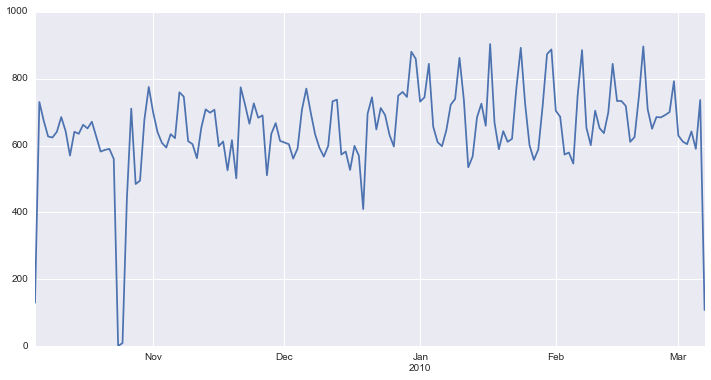

In [142]:
df.time.value_counts().resample('d', how='sum').plot()

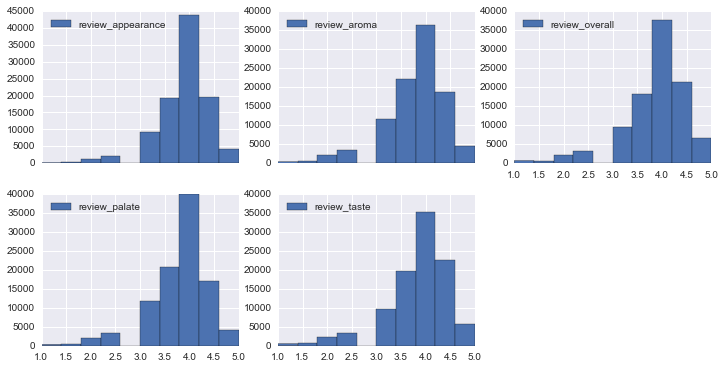

In [143]:
axes = df[review_cols].plot(kind='hist', subplots=True, layout=(2, 3))
[ax.set_ylabel('') for ax in axes.ravel()];

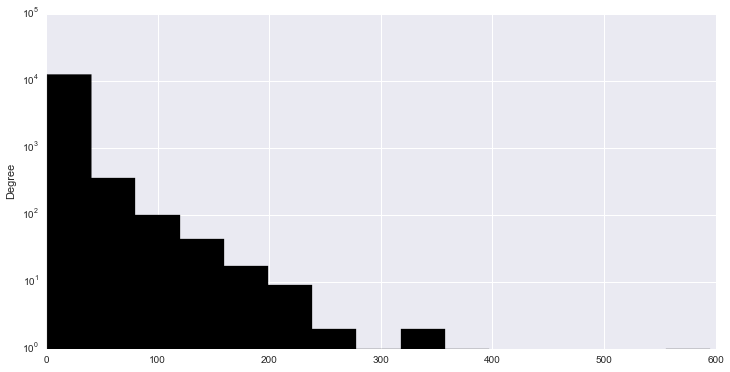

In [396]:
df.beer_id.value_counts().plot(kind='hist', bins=15, color='k', log=True)

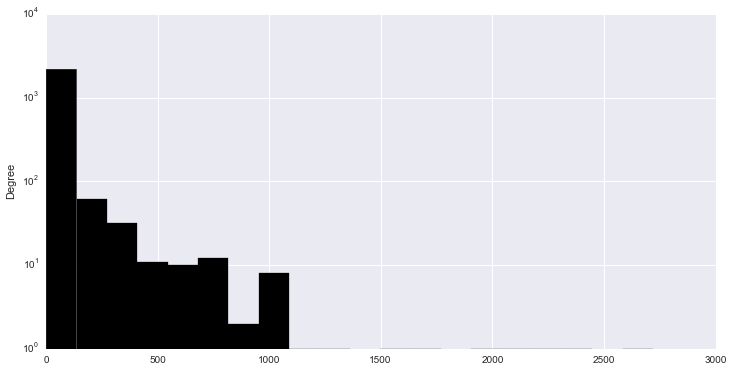

In [402]:
df.brewer_id.value_counts().plot(kind='hist', bins=20, color='k', log=True)
ax.set_title("Log number of reviews")

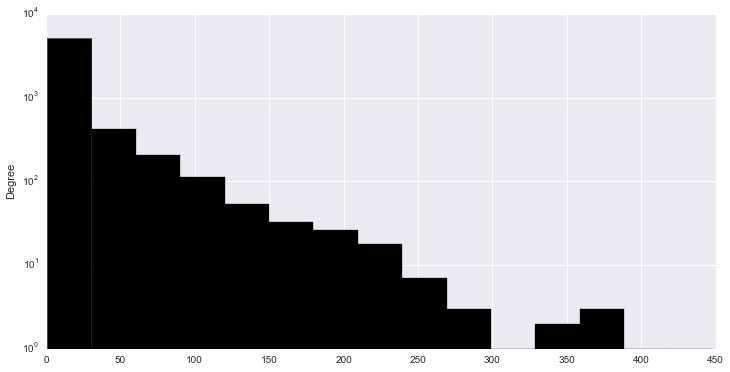

In [404]:
df.profile_name.value_counts().plot(kind='hist', bins=15, color='k', log=True)

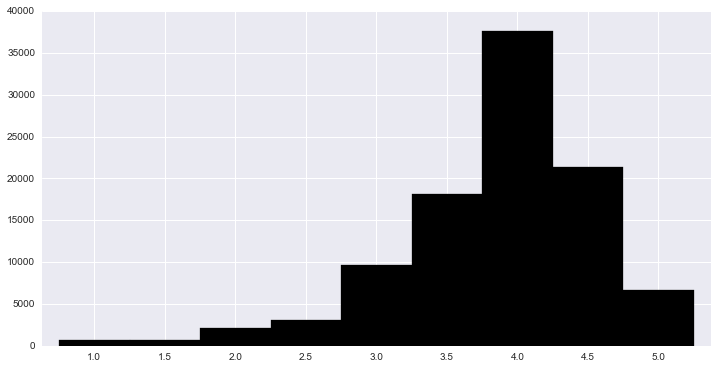

In [147]:
df.review_overall.value_counts().sort_index().plot(kind='bar', width=1, color='k', rot=0)

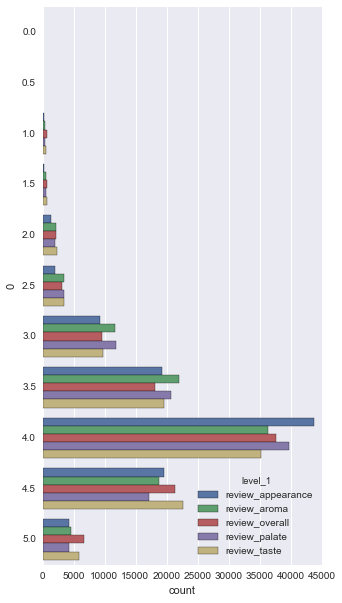

In [148]:
fig, ax = plt.subplots(figsize=(5, 10))
sns.countplot(hue='level_1', y=0, data=df[review_cols].stack().reset_index(level=1), ax=ax,
              order=np.arange(0, 5.5, .5))

# Groupby

In [51]:
df.groupby?

```python
df.groupby( grouper )
```

`grouper` can be many things

- Series (or string indicating a column in `df`)
- function (to be applied on the index)
- dict : *values*
- `levels=[]`, names of levels in a MultiIndex

In [149]:
gr = df.groupby('beer_style')
gr

Haven't really done anything yet. Just some book-keeping.

We can select a column (`review_aroma`) and apply a function (`mean`).

In [150]:
gr['review_aroma'].mean()

beer_style
Altbier                       3.599693
American Adjunct Lager        2.501012
American Amber / Red Ale      3.675518
American Amber / Red Lager    3.243689
American Barleywine           4.000556
                                ...   
Vienna Lager                  3.459963
Weizenbock                    4.041441
Wheatwine                     4.056769
Winter Warmer                 3.716659
Witbier                       3.631773
Name: review_aroma, dtype: float64

Multiple Aggregations on one column

In [151]:
gr['review_aroma'].agg(['mean', 'std', 'count']).head()

,mean,std,count
beer_style,,,
Altbier,3.599693,0.568426,326
American Adjunct Lager,2.501012,0.720936,1482
American Amber / Red Ale,3.675518,0.626926,2749
American Amber / Red Lager,3.243689,0.613034,515
American Barleywine,4.000556,0.514814,1797


In [152]:
gr['review_aroma'].agg([np.mean, np.std, 'count']).head()

,mean,std,count
beer_style,,,
Altbier,3.599693,0.568426,326
American Adjunct Lager,2.501012,0.720936,1482
American Amber / Red Ale,3.675518,0.626926,2749
American Amber / Red Lager,3.243689,0.613034,515
American Barleywine,4.000556,0.514814,1797


Single Aggregation on multiple columns

In [153]:
gr[review_cols].mean()

,review_appearance,review_aroma,review_overall,review_palate,review_taste
beer_style,,,,,
Altbier,3.819018,3.599693,3.774540,3.684049,3.696319
American Adjunct Lager,2.802632,2.501012,3.088731,2.743252,2.705128
American Amber / Red Ale,3.853947,3.675518,3.864496,3.712805,3.759913
American Amber / Red Lager,3.566019,3.243689,3.600971,3.358252,3.408738
American Barleywine,4.001948,4.000556,3.893434,3.971619,4.040345
...,...,...,...,...,...
Vienna Lager,3.766294,3.459963,3.837989,3.620112,3.634078
Weizenbock,4.027928,4.041441,4.084685,4.068468,4.111712
Wheatwine,3.945415,4.056769,3.813319,4.004367,4.066594


Multiple aggregations on multiple columns

In [154]:
gr[review_cols].agg(['mean', 'count', 'std'])

review_appearance                 review_aroma  \
                                        mean count       std         mean   
beer_style                                                                  
Altbier                             3.819018   326  0.559731     3.599693   
American Adjunct Lager              2.802632  1482  0.750881     2.501012   
American Amber / Red Ale            3.853947  2749  0.532465     3.675518   
American Amber / Red Lager          3.566019   515  0.601159     3.243689   
American Barleywine                 4.001948  1797  0.495381     4.000556   
...                                      ...   ...       ...          ...   
Vienna Lager                        3.766294   537  0.584182     3.459963   
Weizenbock                          4.027928   555  0.510392     4.041441   
Wheatwine                           3.945415   458  0.493138     4.056769   
Winter Warmer                       3.849075  2107  0.493310     3.716659   
Witbier                             3.647826  1495  0.591286     3.631773   

                                           review_overall                  \
                           count       std           mean count       std   
beer_style                                                                  
Altbier                      326  0.568426       3.774540   326  0.676367   
American Adjunct Lager      1482  0.720936       3.088731  1482  0.961824   
American Amber / Red Ale    2749  0.626926       3.864496  2749  0.649929   
American Amber / Red Lager   515  0.613034       3.600971   515  0.768101   
American Barleywine         1797  0.514814       3.893434  1797  0.594070   
...                          ...       ...            ...   ...       ...   
Vienna Lager                 537  0.620528       3.837989   537  0.702348   
Weizenbock                   555  0.481699       4.084685   555  0.586429   
Wheatwine                    458  0.548569       3.813319   458  0.650347   
Winter Warmer               2107  0.571915       3.759848  2107  0.631923   
Witbier                     1495  0.599275       3.755853  1495  0.717391   

                           review_palate                 review_taste        \
                                    mean count       std         mean count   
beer_style                                                                    
Altbier                         3.684049   326  0.601171     3.696319   326   
American Adjunct Lager          2.743252  1482  0.777189     2.705128  1482   
American Amber / Red Ale        3.712805  2749  0.592133     3.759913  2749   
American Amber / Red Lager      3.358252   515  0.624799     3.408738   515   
American Barleywine             3.971619  1797  0.538368     4.040345  1797   
...                                  ...   ...       ...          ...   ...   
Vienna Lager                    3.620112   537  0.619194     3.634078   537   
Weizenbock                      4.068468   555  0.511419     4.111712   555   
Wheatwine                       4.004367   458  0.600859     4.066594   458   
Winter Warmer                   3.694115  2107  0.576365     3.734457  2107   
Witbier                         3.598328  1495  0.622560     3.631438  1495   

                                      
                                 std  
beer_style                            
Altbier                     0.624957  
American Adjunct Lager      0.813102  
American Amber / Red Ale    0.651262  
American Amber / Red Lager  0.699792  
American Barleywine         0.555808  
...                              ...  
Vienna Lager                0.667539  
Weizenbock                  0.518735  
Wheatwine                   0.612987  
Winter Warmer               0.627473  
Witbier                     0.674364  

[104 rows x 15 columns]

Hierarchical Indexes in the columns can be awkward to work with, so I'll usually
move a level to the Index with `.stack`.

In [155]:
gr[review_cols].agg(['mean', 'count', 'std']).stack(level=0)

mean  count       std
beer_style                                             
Altbier    review_appearance  3.819018    326  0.559731
           review_aroma       3.599693    326  0.568426
           review_overall     3.774540    326  0.676367
           review_palate      3.684049    326  0.601171
           review_taste       3.696319    326  0.624957
...                                ...    ...       ...
Witbier    review_appearance  3.647826   1495  0.591286
           review_aroma       3.631773   1495  0.599275
           review_overall     3.755853   1495  0.717391
           review_palate      3.598328   1495  0.622560
           review_taste       3.631438   1495  0.674364

[520 rows x 3 columns]

You can group by **levels** of a MultiIndex.

In [156]:
multi = gr[review_cols].agg(['mean', 'count', 'std']).stack(level=0)
multi.head()

mean  count       std
beer_style                                             
Altbier    review_appearance  3.819018    326  0.559731
           review_aroma       3.599693    326  0.568426
           review_overall     3.774540    326  0.676367
           review_palate      3.684049    326  0.601171
           review_taste       3.696319    326  0.624957

In [157]:
multi.groupby(level='beer_style')['mean'].agg(['min', 'max'])

,min,max
beer_style,,
Altbier,3.599693,3.819018
American Adjunct Lager,2.501012,3.088731
American Amber / Red Ale,3.675518,3.864496
American Amber / Red Lager,3.243689,3.600971
American Barleywine,3.893434,4.040345
...,...,...
Vienna Lager,3.459963,3.837989
Weizenbock,4.027928,4.111712
Wheatwine,3.813319,4.066594


Group by multiple columns

In [158]:
df.groupby(['brewer_id', 'beer_style']).review_overall.mean()

brewer_id  beer_style                    
1          Czech Pilsener                    3.943662
3          American Adjunct Lager            3.750000
           American Amber / Red Ale          3.750000
           American Brown Ale                3.324324
           American Double / Imperial IPA    4.333333
                                               ...   
24926      Belgian Strong Dark Ale           4.000000
           Fruit / Vegetable Beer            4.500000
24964      American Malt Liquor              3.600000
25680      Euro Pale Lager                   3.500000
27039      American Double / Imperial IPA    4.875000
Name: review_overall, dtype: float64

In [159]:
df.groupby(['brewer_id', 'beer_style'])[review_cols].mean()

review_appearance  review_aroma  \
brewer_id beer_style                                                        
1         Czech Pilsener                           3.605634      3.514085   
3         American Adjunct Lager                   3.250000      2.500000   
          American Amber / Red Ale                 3.666667      3.472222   
          American Brown Ale                       3.513514      3.270270   
          American Double / Imperial IPA           3.833333      3.833333   
...                                                     ...           ...   
24926     Belgian Strong Dark Ale                  3.500000      3.500000   
          Fruit / Vegetable Beer                   4.500000      4.500000   
24964     American Malt Liquor                     3.300000      2.800000   
25680     Euro Pale Lager                          4.000000      3.500000   
27039     American Double / Imperial IPA           4.625000      4.750000   

                                          review_overall  review_palate  \
brewer_id beer_style                                                      
1         Czech Pilsener                        3.943662       3.633803   
3         American Adjunct Lager                3.750000       3.500000   
          American Amber / Red Ale              3.750000       3.486111   
          American Brown Ale                    3.324324       3.081081   
          American Double / Imperial IPA        4.333333       3.833333   
...                                                  ...            ...   
24926     Belgian Strong Dark Ale               4.000000       4.000000   
          Fruit / Vegetable Beer                4.500000       4.500000   
24964     American Malt Liquor                  3.600000       3.200000   
25680     Euro Pale Lager                       3.500000       3.500000   
27039     American Double / Imperial IPA        4.875000       4.875000   

                                          review_taste  
brewer_id beer_style                                    
1         Czech Pilsener                      3.718310  
3         American Adjunct Lager              2.750000  
          American Amber / Red Ale            3.583333  
          American Brown Ale                  3.175676  
          American Double / Imperial IPA      3.833333  
...                                                ...  
24926     Belgian Strong Dark Ale             4.000000  
          Fruit / Vegetable Beer              4.500000  
24964     American Malt Liquor                3.400000  
25680     Euro Pale Lager                     3.500000  
27039     American Double / Imperial IPA      4.875000  

[10432 rows x 5 columns]

Exercise: Plot the relationship between review length (the `text` column) and average `review_overall`.

In [160]:
# Your code goes here

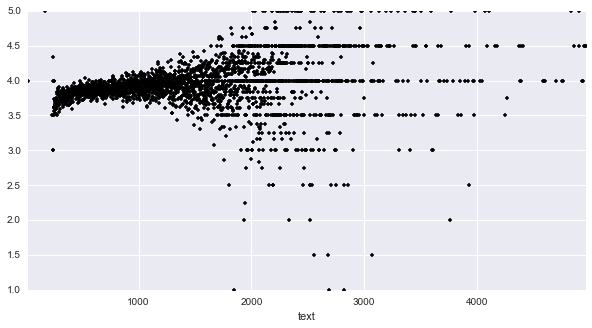

In [162]:
%load -r 1:5 solutions_groupby.py

Exercise: Which **brewer** (`brewer_id`) has the largest gap between the min and max `review_overall` for two of their beers.

In [163]:
# Your code goes here. You've got this!

In [165]:
# %load -r 6:13 solutions_groupby.py
# question
avg = (df.groupby(['brewer_id', 'beer_name'])
       .review_overall
       .mean())
extrema = avg.groupby(level='brewer_id').agg(['min', 'max'])
difference = extrema['max'] - extrema['min']
difference.order(ascending=False)

brewer_id
29      4
506     4
478     4
435     4
688     4
       ..
6266    0
884     0
882     0
6272    0
4410    0
dtype: float64

In [168]:
# Show for those with counts > 20ish

In [169]:
style = df.beer_style

In [170]:
style.replace({
    'india pale ale': 'ipa',
    'american pale ale': 'apa'
})

0                        American Stout
1                       American Porter
2                       German Pilsener
3        American Double / Imperial IPA
4               American Pale Ale (APA)
                      ...              
99995                      American IPA
99996          American Amber / Red Ale
99997                   American Porter
99998                      American IPA
99999            Fruit / Vegetable Beer
Name: beer_style, dtype: object

In [171]:
kinds = ['ipa', 'apa', 'amber ale', 'rye', 'scotch', 'stout', 'barleywine', 'porter', 'brown ale', 'lager', 'pilsner',
         'tripel', 'biter', 'farmhouse', 'malt liquour', 'rice']

In [172]:
expr = '|'.join(['(?P<{name}>{pat})'.format(pat=kind, name=kind.replace(' ', '_')) for kind in kinds])
expr

'(?P<ipa>ipa)|(?P<apa>apa)|(?P<amber_ale>amber ale)|(?P<rye>rye)|(?P<scotch>scotch)|(?P<stout>stout)|(?P<barleywine>barleywine)|(?P<porter>porter)|(?P<brown_ale>brown ale)|(?P<lager>lager)|(?P<pilsner>pilsner)|(?P<tripel>tripel)|(?P<biter>biter)|(?P<farmhouse>farmhouse)|(?P<malt_liquour>malt liquour)|(?P<rice>rice)'

In [173]:
style.str.replace('India Pale Ale', 'IPA')

0                        American Stout
1                       American Porter
2                       German Pilsener
3        American Double / Imperial IPA
4               American Pale Ale (APA)
                      ...              
99995                      American IPA
99996          American Amber / Red Ale
99997                   American Porter
99998                      American IPA
99999            Fruit / Vegetable Beer
Name: beer_style, dtype: object

In [174]:
beer_kind = (style.replace({
    'india pale ale': 'ipa',
    'american pale ale': 'apa'
})
 .str.extract(expr, flags=re.IGNORECASE).fillna('').sum(1)
 .str.lower().replace('', 'other')
)

In [175]:
df.groupby(['brewer_id', beer_kind]).review_overall.mean()

brewer_id           
1          other        3.943662
3          apa          3.347826
           brown ale    3.582418
           ipa          3.662791
           lager        3.772727
                          ...   
23980      porter       3.681818
24926      other        4.166667
24964      other        3.600000
25680      lager        3.500000
27039      ipa          4.875000
Name: review_overall, dtype: float64

# Transform

Combined Series / DataFrame is the same shape as the input. For example, say you want to standardize the reviews by subtracting the mean.

In [415]:
def de_mean(reviews):
    s = reviews - reviews.mean()
    return s

In [407]:
de_mean(df.review_overall)

0        0.63927
1        0.63927
2       -0.86073
3        0.13927
4        0.13927
          ...   
99995    0.63927
99996    0.13927
99997   -1.36073
99998    0.13927
99999    0.63927
Name: review_overall, dtype: float64

We can do this at the *person* level with `groupby` and `transform`.

In [410]:
df.groupby('profile_name').transform(de_mean)

,abv,beer_id,brewer_id,review_appearance,review_aroma,review_overall,review_palate,review_taste
0,-2.763000,-14386.800000,-250.800000,0.350000,-0.050000,0.500000,-0.100000,0.450000
1,-1.622833,-8941.000000,4594.447761,0.462687,0.082090,0.395522,0.044776,-0.014925
2,-2.420000,-11859.162500,450.287500,0.025000,-0.968750,-0.875000,-0.631250,-0.350000
3,1.673333,-6783.687500,-1250.687500,0.250000,0.281250,0.093750,0.375000,0.312500
4,-1.996861,-25015.457746,-2934.570423,0.242958,-0.774648,0.295775,-0.242958,-0.683099
...,...,...,...,...,...,...,...,...
99995,-0.536528,-12955.893333,2269.973333,0.040000,0.580000,0.466667,0.520000,0.520000
99996,0.118182,-8688.272727,-3685.636364,0.090909,0.045455,0.090909,-0.181818,0.090909
99997,-0.500000,-822.000000,-201.500000,0.375000,-0.500000,-1.250000,0.250000,-0.375000
99998,-0.060876,-40408.033766,-6994.153247,-0.720779,0.331169,0.410390,-0.049351,0.468831


In [412]:
user_counts = df.profile_name.value_counts()
top_users = user_counts[user_counts > user_counts.quantile(.8)].index

In [413]:
top_users

Index(['Mora2000', 'drabmuh', 'northyorksammy', 'nickd717', 'jrallen34',
       'womencantsail', 'corby112', 'BeerFMAndy', 'glid02', 'mikesgroove', 
       ...
       'SpecialK088', 'TerryW', 'IBUnit63', 'nickadams2', 'UDbeernut',
       'Liverpool08', 'aggiearcher13', 'mithrascruor', 'BBri', 'WWWade'],
      dtype='object', length=1192)

In [416]:
by_profile = df[df.profile_name.isin(top_users)].groupby('profile_name')
standardized = by_profile[review_cols].transform(de_mean)
standardized

,review_appearance,review_aroma,review_overall,review_palate,review_taste
1,0.462687,0.082090,0.395522,0.044776,-0.014925
2,0.025000,-0.968750,-0.875000,-0.631250,-0.350000
4,0.242958,-0.774648,0.295775,-0.242958,-0.683099
5,-0.135593,0.161017,-0.415254,0.084746,0.478814
6,-0.159389,0.091703,0.303493,-0.010917,0.447598
...,...,...,...,...,...
99991,0.211180,0.813665,-0.310559,0.388199,0.409938
99994,0.279221,0.331169,0.410390,-0.049351,-0.031169
99995,0.040000,0.580000,0.466667,0.520000,0.520000
99998,-0.720779,0.331169,0.410390,-0.049351,0.468831


In [417]:
pd.concat([df, standardized.add_prefix('std_')], axis=1).head()

,abv,beer_id,brewer_id,beer_name,beer_style,review_appearance,review_aroma,review_overall,review_palate,profile_name,review_taste,text,time,std_review_appearance,std_review_aroma,std_review_overall,std_review_palate,std_review_taste
0,7.0,2511,287,Bell's Cherry Stout,American Stout,4.5,4,4.5,4.0,blaheath,4.5,Batch 8144\tPitch black in color with a 1/2 f...,2009-10-05 21:31:48,NaN,NaN,NaN,NaN,NaN
1,5.7,19736,9790,Duck-Rabbit Porter,American Porter,4.5,4,4.5,4.0,GJ40,4.0,Sampled from a 12oz bottle in a standard pint...,2009-10-05 21:32:09,0.462687,0.082090,0.395522,0.044776,-0.014925
2,4.8,11098,3182,Fürstenberg Premium Pilsener,German Pilsener,4.0,3,3.0,3.0,biegaman,3.5,Haystack yellow with an energetic group of bu...,2009-10-05 21:32:13,0.025000,-0.968750,-0.875000,-0.631250,-0.350000
3,9.5,28577,3818,Unearthly (Imperial India Pale Ale),American Double / Imperial IPA,4.0,4,4.0,4.0,nick76,4.0,"The aroma has pine, wood, citrus, caramel, an...",2009-10-05 21:32:37,NaN,NaN,NaN,NaN,NaN
4,5.8,398,119,Wolaver's Pale Ale,American Pale Ale (APA),4.0,3,4.0,3.5,champ103,3.0,A: Pours a slightly hazy golden/orange color....,2009-10-05 21:33:14,0.242958,-0.774648,0.295775,-0.242958,-0.683099


In [418]:
style_counts = df.beer_style.value_counts()
top_styles = style_counts[style_counts > 1000].index
top_styles

Index(['American IPA', 'American Double / Imperial IPA',
       'American Double / Imperial Stout', 'Russian Imperial Stout',
       'American Porter', 'American Pale Ale (APA)', 'American Strong Ale',
       'American Amber / Red Ale', 'Belgian Strong Dark Ale', 'Winter Warmer',
       'American Stout', 'Fruit / Vegetable Beer', 'American Barleywine',
       'Saison / Farmhouse Ale', 'American Wild Ale', 'American Brown Ale',
       'Tripel', 'Belgian Strong Pale Ale', 'Witbier',
       'American Adjunct Lager', 'Märzen / Oktoberfest', 'Doppelbock',
       'Hefeweizen', 'Scotch Ale / Wee Heavy', 'Oatmeal Stout',
       'Czech Pilsener', 'Pumpkin Ale', 'Belgian Pale Ale',
       'American Pale Wheat Ale', 'Dubbel', 'Old Ale', 'English Brown Ale',
       'English Pale Ale'],
      dtype='object')

In [419]:
df.query('beer_style in @top_styles').groupby('beer_style')[review_cols].std().sort('review_overall', ascending=False)

,review_appearance,review_aroma,review_overall,review_palate,review_taste
beer_style,,,,,
American Adjunct Lager,0.750881,0.720936,0.961824,0.777189,0.813102
Fruit / Vegetable Beer,0.662958,0.784562,0.897954,0.744376,0.878298
Pumpkin Ale,0.538920,0.678338,0.741914,0.655294,0.730874
American Pale Wheat Ale,0.566832,0.668443,0.736956,0.627013,0.708388
Witbier,0.591286,0.599275,0.717391,0.622560,0.674364
...,...,...,...,...,...
English Brown Ale,0.510767,0.544004,0.614923,0.594584,0.576359
American IPA,0.487279,0.588062,0.612685,0.527316,0.595619
Dubbel,0.522164,0.566321,0.611108,0.618170,0.630782


# Aside: Beer Recommender

See [Harvard CS109](https://github.com/cs109/content) for a more complete example.

In [420]:
deduped = df.groupby(['beer_id', 'profile_name']).review_overall.mean().reset_index()
deduped.head()

,beer_id,profile_name,review_overall
0,5,Ek0nomik,3.0
1,5,HalfFull,4.5
2,5,Jesstyr,4.0
3,5,JordonHoltzman,4.0
4,5,KTCamm,4.0


In [432]:
user_counts = deduped.profile_name.value_counts().order()
top_users = user_counts[user_counts > user_counts.quantile(.75)].index

In [433]:
beer_counts = deduped.beer_id.value_counts()
top_beers = beer_counts[beer_counts > beer_counts.quantile(.9)].index

In [434]:
top = deduped.query('beer_id in @top_beers and profile_name in @top_users')
user_means = top.groupby('profile_name').review_overall.mean()
beer_means = top.groupby('beer_id').review_overall.mean()
overall_means = top.mean()

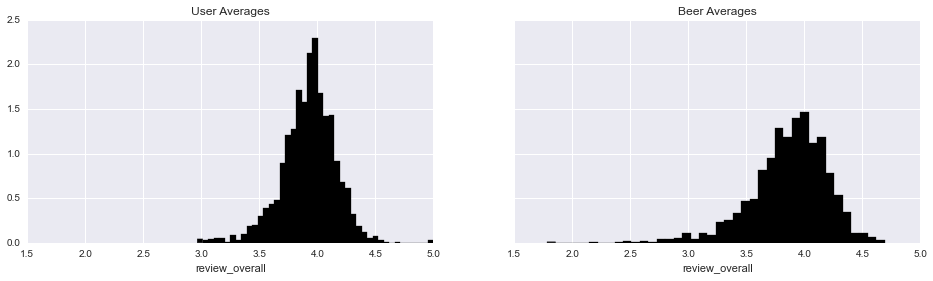

In [435]:
fig, axes = plt.subplots(figsize=(16, 4), ncols=2, sharey=True, sharex=True)

sns.distplot(user_means, kde=False, ax=axes[0], color='k', norm_hist=True, hist_kws={'alpha': 1})
sns.distplot(beer_means, kde=False, ax=axes[1], color='k', norm_hist=True, hist_kws={'alpha': 1})
axes[0].set_title("User Averages")
axes[1].set_title("Beer Averages")

In [441]:
s = top.set_index(['beer_id', 'profile_name']).review_overall
s.head()

beer_id  profile_name  
5        Ek0nomik          3.0
         HalfFull          4.5
         Jesstyr           4.0
         JordonHoltzman    4.0
         KTCamm            4.0
Name: review_overall, dtype: float64

In [445]:
standardized = s.groupby(level='profile_name').transform(de_mean)
standardized.head()

beer_id  profile_name  
5        Ek0nomik         -0.857143
         HalfFull          0.789474
         Jesstyr           0.244318
         JordonHoltzman    0.222222
         KTCamm            0.166667
Name: review_overall, dtype: float64

In [446]:
from scipy.stats import pearsonr

In [505]:
def pearson_sim(common_reviews, reg=2):
    """
    Pearson correlation coefficient between sets
    of reviews for two beers, made by a common subset
    of reviewers.
    
    `common_reviews` should be an N x 2 DataFrame where
    N is the number of people who've reviewd both beers.
    """
    n_common = len(common_reviews)
    if n_common == 0:
        return 0, 0
    rho = pearsonr(common_reviews.iloc[:, 0], common_reviews.iloc[:, 1])[0]
    similarity = (n_common * rho) / (n_common + reg)
    return similarity, n_common

In [506]:
def beer_similarity(standardized, beer_1, beer_2, simfunc=simfunc, **kwargs):
    """
    Compute the similarity between two beers.
    
    """
    # get common subset...
    reviewers_1 = standardized.loc[beer_1].index
    reviewers_2 = standardized.loc[beer_2].index
    common_idx = reviewers_1 & reviewers_2  # set intersection

    # slice the Multiindex, unstack to be N x 2
    common_reviews = standardized.loc[[beer_1, beer_2], common_idx].unstack('beer_id')
    # ... review similairty for subset
    rho, n_common = simfunc(common_reviews, **kwargs)
    return rho, n_common

In [508]:
beer_ids = s.index.levels[0]
len(beer_ids)

1264

In [509]:
%%time
sims = []

for i, beer_1 in enumerate(beer_ids):
    for j, beer_2 in enumerate(beer_ids):
        if j >= i:
            continue
        sim, n_common = beer_similarity(s, beer_1, beer_2)
        sims.append((beer_1, beer_2, sim, n_common))
        print((i, j), end='\r')

CPU times: user 51min 33s, sys: 50.4 s, total: 52min 24s
Wall time: 53min 7s


In [510]:
sim = pd.DataFrame(sims, columns=['beer_1', 'beer_2', 'score', 'n_common'])
sim.to_csv('beer_subset_similarity.csv', index=False)

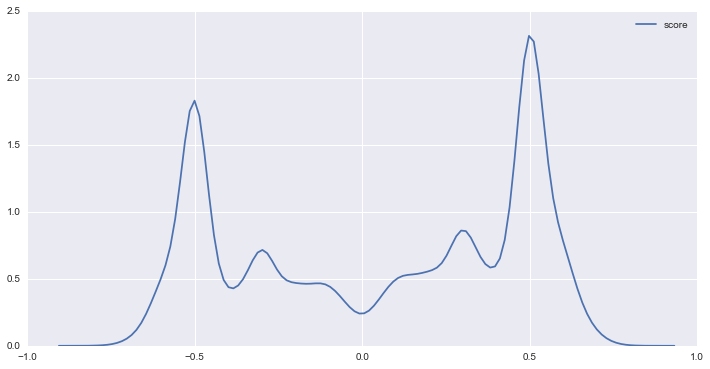

In [531]:
sns.kdeplot(sim[sim.score != 0].dropna().score)

In [525]:
s.loc[[36, 5]].unstack(0).dropna()

beer_id,5,36
profile_name,,


In [339]:
sim = sim.set_index(['beer_1', 'beer_2']).score

In [351]:
s.loc[6].isnull().any()

False

In [352]:
beer_similarity(s, 10, 6)

(nan, 117)

In [354]:
    reviewers_1 = s.loc[beer_1].index
    reviewers_2 = s.loc[beer_2].index
    common = reviewers_1 & reviewers_2

In [359]:
deltas = s.sub(s.groupby(level='beer_id').mean(), level=0)
# deltas = deltas.loc[[beer_1, beer_2]].unstack(level=0)
# rho = pearsonr(deltas[beer_1], deltas[beer_2])[0]



In [365]:
sub = s.loc[:, common]

In [368]:
sub.sub(sub.groupby(level='beer_id').mean())

beer_id  profile_name
5        donkeyrunner    0
6        donkeyrunner    0
7        donkeyrunner    0
10       donkeyrunner    0
30       donkeyrunner    0
                        ..
53941    donkeyrunner    0
54089    donkeyrunner    0
54540    donkeyrunner    0
54904    donkeyrunner    0
55547    donkeyrunner    0
Name: review_overall, dtype: float64

In [360]:
deltas

beer_id  profile_name    
5        Ek0nomik           -0.789474
         HalfFull            0.710526
         Jesstyr             0.210526
         KTCamm              0.210526
         KrisPaulk77         0.210526
                               ...   
63224    rtratzlaff          0.093750
         ruckus232           0.093750
         smibroncos         -0.406250
         superdedooperboy    0.093750
         tooyoung            0.593750
Name: review_overall, dtype: float64

In [355]:
common

Index(['donkeyrunner'], dtype='object', name='profile_name')

In [353]:
beer_1 = 10
beer_2 = 6

In [344]:
sim.loc[10]

beer_2
5    0.987730
6         NaN
7    0.989744
Name: score, dtype: float64

In [342]:
sim[sim != 0].dropn()

beer_1  beer_2
6       5         0.360911
7       5         0.341912
        6         0.690432
10      5         0.987730
        6              NaN
                    ...   
63224   55900     0.763249
        56032    -0.976190
        56068          NaN
        56074          NaN
        57341          NaN
Name: score, dtype: float64

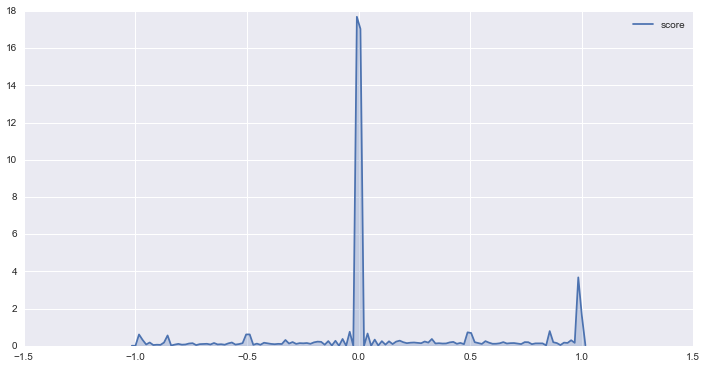

In [330]:
sns.kdeplot(sim, shade=True)

In [137]:
top.beer_id.value_counts()

1904     190
355      186
56973    170
276      169
92       168
        ... 
16403     13
4355      13
1882      13
3637      13
16441     12
dtype: int64

In [140]:
sim.loc[1904].nlargest(10)

beer_2
617     0.813125
21      0.786629
325     0.776602
750     0.725000
272     0.661823
1796    0.650682
982     0.647806
1606    0.633333
682     0.617175
347     0.594322
Name: score, dtype: float64

In [142]:
df[df.beer_id.isin([1904, 617])]

,abv,beer_id,brewer_id,beer_name,beer_style,review_appearance,review_aroma,review_overall,review_palate,profile_name,review_taste,text,time
304,6.5,617,195,Troubadour Blond Ale,Belgian Pale Ale,4.5,4.5,4.5,4.5,Jason,5.0,Presentation: Slender 11.2 oz brown euro styl...,2001-01-25 22:53:56
1553,6.8,1904,140,Sierra Nevada Celebration Ale,American IPA,4.0,4.0,4.0,4.0,mattmaples,5.0,This is a good winter / Stong ale. Real big f...,2001-11-03 17:56:36
1626,6.8,1904,140,Sierra Nevada Celebration Ale,American IPA,5.0,5.0,5.0,5.0,pbrian,5.0,This is why I drink beer. All year long is m...,2001-11-08 10:46:56
1641,6.8,1904,140,Sierra Nevada Celebration Ale,American IPA,5.0,4.0,5.0,5.0,John,5.0,Every year when Nov. rolls around one of the ...,2001-11-09 09:27:55
1643,6.8,1904,140,Sierra Nevada Celebration Ale,American IPA,4.0,4.0,4.0,4.0,Brent,5.0,Huge and hoppy. This year's edition seemed e...,2001-11-09 09:41:42
...,...,...,...,...,...,...,...,...,...,...,...,...,...
97006,6.8,1904,140,Sierra Nevada Celebration Ale,American IPA,4.5,4.5,4.0,4.5,bnuttz,4.0,"2003 edition of the Celebration Ale, in a 12 ...",2004-04-12 05:03:42
97035,6.8,1904,140,Sierra Nevada Celebration Ale,American IPA,3.5,4.0,3.5,3.5,GreenCard,4.0,"Appearance: hazelnut brown, good clarity, not...",2004-04-12 14:52:38
98329,6.8,1904,140,Sierra Nevada Celebration Ale,American IPA,4.0,4.0,4.0,4.0,longpondbeerman,4.5,"The 2003 bottle edition pours a lovely, bubbl...",2004-04-19 21:18:56
99571,6.8,1904,140,Sierra Nevada Celebration Ale,American IPA,5.0,4.5,4.5,4.0,Joey7F,5.0,WOW!! I am so stoked! I just turned 21 (end o...,2004-04-26 21:52:09


TODO: person side.
TODO: shrinkage

In [133]:
sim

beer_1  beer_2
6       5         0.001360
7       5         0.541936
        6         0.365374
9       5         0.645497
        6         0.065164
                    ...   
56973   47785     0.327276
        48050     0.075428
        51300    -0.044591
        51558    -0.239325
        51959     0.141093
Name: score, dtype: float64

In [417]:
X = df.set_index(['brewer_id','profile_name'], append=True).sort_index().review_overall

In [418]:
X.loc[slice(None), slice(None), 'stcules']

       brewer_id
0      10325        1.5
1      10325        3.0
2      10325        3.0
3      10325        3.0
1534   16604        4.0
                   ... 
98242  16536        4.5
98269  16536        3.5
98275  16536        3.5
98681  183          2.5
98871  183          3.0
Name: review_overall, dtype: float64

In [ ]:
pearson_sim()

In [61]:
def hm(x, y, **kwargs):
    ratings = np.arange(0, 5.5, .5)
    grid = (pd.concat([x, y], axis=1)
              .assign(n=1)
              .groupby([x.name, y.name]).n.sum()
              .unstack()
              .reindex(index=ratings, columns=ratings)
              .sort_index(ascending=False))
    sns.heatmap(grid, ax=plt.gca(), cbar=False, square=True)

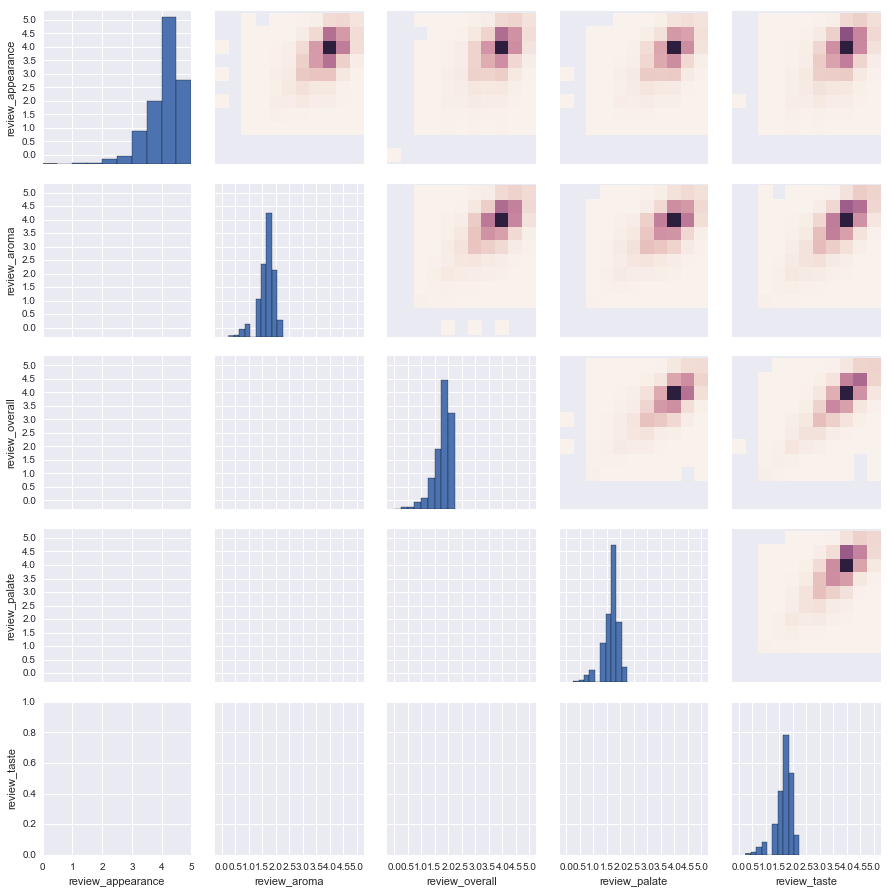

In [62]:
g = sns.PairGrid(df[review_cols])
g.map_upper(hm)
g.map_diag(plt.hist)

In [131]:
df.groupby(df.brewer_id.isin(ecclectic_brewers)).mean()

,abv,beer_id,brewer_id,review_appearance,review_aroma,review_overall,review_palate,review_taste
brewer_id,,,,,,,,
False,6.859996,23855.965276,3752.719210,3.753874,3.660576,3.733939,3.661322,3.697032
True,7.870967,28449.897874,3632.194312,4.054861,3.990960,4.029596,3.984891,4.066066


In [116]:
gr = df.groupby(['brewer_id', 'beer_style'])
f = gr.review_overall.agg(['mean', 'count'])

In [118]:
gr.agg(['mean', 'std', 'count'])

abv                      \
                                                mean           std count   
brewer_id beer_style                                                       
1          Baltic Porter                    7.000000  0.000000e+00     4   
           Czech Pilsener                   4.418392  1.339966e-01  1343   
           Euro Strong Lager                6.700000           NaN     6   
           Vienna Lager                     5.300000  0.000000e+00     4   
2          American Blonde Ale                   NaN           NaN     0   
           American Dark Wheat Ale               NaN           NaN     0   
           American IPA                          NaN           NaN     0   
           American Pale Ale (APA)               NaN           NaN     0   
           American Pale Wheat Ale               NaN           NaN     0   
           American Porter                       NaN           NaN     0   
           American Stout                        NaN           NaN     0   
           English Brown Ale                     NaN           NaN     0   
5          American Amber / Red Ale              NaN           NaN     0   
           American Blonde Ale              4.600000           NaN     1   
           American IPA                     5.000000  0.000000e+00    84   
           American Pale Ale (APA)          5.126882  9.684118e-02    93   
           English India Pale Ale (IPA)     4.200000  2.816263e-07    84   
           English Porter                   4.000000  0.000000e+00   121   
           Fruit / Vegetable Beer                NaN           NaN     0   
           Hefeweizen                            NaN           NaN     0   
           Herbed / Spiced Beer                  NaN           NaN     0   
           Russian Imperial Stout           6.000000  0.000000e+00    86   
           Scottish Ale                     4.700000  2.018952e-07    85   
           Winter Warmer                         NaN           NaN     0   
14         Altbier                          4.900000  0.000000e+00     2   
           American Amber / Red Ale         4.919118  5.322927e-01    34   
           American Barleywine             11.475610  1.090424e-01    41   
           American Brown Ale               6.300000  9.733398e-08     3   
           American Double / Imperial IPA   9.000000  0.000000e+00    32   
           American IPA                     6.579592  3.906007e-01    98   
...                                              ...           ...   ...   
26946      American Malt Liquor             7.000000  0.000000e+00     8   
26983      English Porter                   4.800000           NaN     1   
26990      American Amber / Red Ale         5.000000  0.000000e+00     3   
           American Black Ale              10.000000           NaN     1   
           American Double / Imperial IPA   8.850000  0.000000e+00     4   
           American IPA                     7.200000  0.000000e+00     2   
           American Pale Ale (APA)          5.500000           NaN     1   
           American Porter                  6.200000  0.000000e+00     6   
           Winter Warmer                    5.850000  1.909188e+00     2   
27021      American Amber / Red Ale              NaN           NaN     0   
           American Blonde Ale                   NaN           NaN     0   
           American IPA                          NaN           NaN     0   
           American Porter                  6.900000           NaN     1   
           Tripel                           8.900000           NaN     1   
27079      American Blonde Ale              5.500000           NaN     1   
27080      Scottish Ale                     3.900000  0.000000e+00     2   
27133      American IPA                     5.900000           NaN     1   
27136      American Pale Ale (APA)          4.800000  0.000000e+00     2   
27361      English Bitter                   3.900000           NaN     1   
27632      American A

In [95]:
styles = ['ipa|india pale ale', 'amber ale', 'stout', 'barleywine', 'porter', 'brown ale', 'lager']

In [96]:
expr = '|'.join([r'(?P<{name}>{x})'.format(name=x.split('|')[0].replace(' ', '_'), x=x) for x in styles])
expr

'(?P<ipa>ipa|india pale ale)|(?P<amber_ale>amber ale)|(?P<stout>stout)|(?P<barleywine>barleywine)|(?P<porter>porter)|(?P<brown_ale>brown ale)|(?P<lager>lager)'

In [104]:
style = df.beer_style.str.extract(expr, flags=re.IGNORECASE)

In [109]:
style = style.fillna('').sum(1)
style

0              
1              
2         Stout
3              
4           IPA
5              
6              
7              
8              
9              
10             
11             
12             
13             
14        Stout
15        Stout
16        Lager
17             
18             
19             
20             
21             
22             
23             
24             
25             
26             
27             
28             
29             
          ...  
199970         
199971         
199972         
199973         
199974         
199975         
199976         
199977         
199978         
199979         
199980         
199981         
199982         
199983         
199984         
199985         
199986         
199987         
199988         
199989         
199990         
199991         
199992         
199993         
199994         
199995         
199996         
199997         
199998         
199999         
dtype: object

In [112]:
gr = df.groupby(style).review_overall

In [61]:
df.beer_style.value_counts()

 American IPA                           24797
 American Double / Imperial Stout       18077
 American Double / Imperial IPA         13590
 American Pale Ale (APA)                 9971
 American Porter                         6769
 American Amber / Red Ale                5701
 American Barleywine                     5589
 Russian Imperial Stout                  4568
 Rye Beer                                4220
 Fruit / Vegetable Beer                  4021
 English Pale Ale                        3988
 Hefeweizen                              3822
 Scotch Ale / Wee Heavy                  3784
 Saison / Farmhouse Ale                  3468
 American Brown Ale                      3367
 American Strong Ale                     3352
 Czech Pilsener                          3211
 Euro Pale Lager                         2955
 American Pale Wheat Ale                 2788
 American Stout                          2669
 Old Ale                                 2664
 Extra Special / Strong Bitter (ES

In [4]:
ecclectic_brewers = df.groupby(['brewer_id']).beer_style.nunique().nlargest(20).index

In [56]:
f

mean  count
brewer_id beer_style                                      
1          Baltic Porter                   4.125000      4
           Czech Pilsener                  3.821668   1343
           Euro Strong Lager               3.416667      6
           Vienna Lager                    3.625000      4
2          American Blonde Ale             3.750000      2
           American Dark Wheat Ale         2.187500      8
           American IPA                    4.166667      3
           American Pale Ale (APA)         4.000000      3
           American Pale Wheat Ale         3.083333      6
           American Porter                 2.416667      6
           American Stout                  3.700000     10
           English Brown Ale               3.500000      2
5          American Amber / Red Ale        3.794118     17
           American Blonde Ale             4.000000      1
           American IPA                    3.702381     84
           American Pale Ale (APA)         3.766667    105
           English India Pale Ale (IPA)    3.250000     84
           English Porter                  4.053719    121
           Fruit / Vegetable Beer          3.000000      1
           Hefeweizen                      3.411458     96
           Herbed / Spiced Beer            3.500000      2
           Russian Imperial Stout          3.709302     86
           Scottish Ale                    3.394118     85
           Winter Warmer                   3.815217     46
14         Altbier                         4.000000      2
           American Amber / Red Ale        3.735294     34
           American Barleywine             4.207317     41
           American Brown Ale              4.333333      3
           American Double / Imperial IPA  4.078125     32
           American IPA                    4.142157    102
...                                             ...    ...
26946      American Malt Liquor            3.125000      8
26983      English Porter                  3.500000      1
26990      American Amber / Red Ale        4.166667      3
           American Black Ale              4.000000      1
           American Double / Imperial IPA  4.125000      4
           American IPA                    4.750000      2
           American Pale Ale (APA)         3.500000      1
           American Porter                 4.166667      6
           Winter Warmer                   4.000000      2
27021      American Amber / Red Ale        3.750000      2
           American Blonde Ale             4.250000      2
           American IPA                    4.125000      4
           American Porter                 4.000000      1
           Tripel                          3.500000      1
27079      American Blonde Ale             4.000000      1
27080      Scottish Ale                    3.500000      2
27133      American IPA                    4.000000      1
27136      American Pale Ale (APA)         3.500000      2
27361      English Bitter                  3.500000      1
27632      American Amber / Red Ale        4.000000      2
           American Blonde Ale             3.000000      1
           American IPA                    4.000000      1
           American Pale Ale (APA)         3.000000      1
           Baltic Porter                   4.000000      1
           English Bitter                  3.000000      1
           English India Pale Ale (IPA)    4.000000      1
           Russian Imperial Stout          4.500000      1
27645      American Pale Ale (APA)         4.500000      1
27797      American Pale Lager             3.250000      4
           Light Lager                     3.250000      2

[5289 rows x 2 columns]

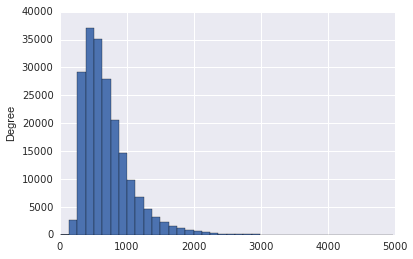

In [16]:
df.text.str.len().plot(kind='hist', bins=40)

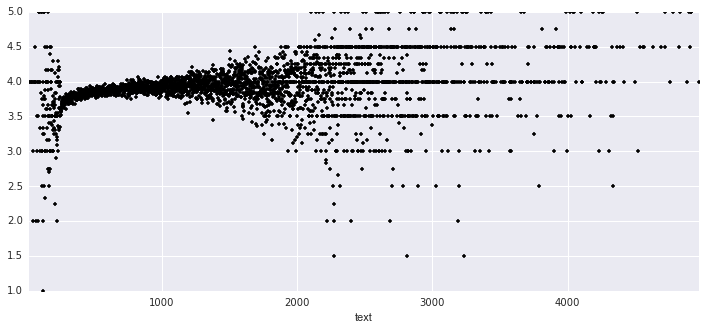

In [23]:
df.groupby(df.text.str.len()).review_overall.mean().plot(style='k.', figsize=(12, 5))

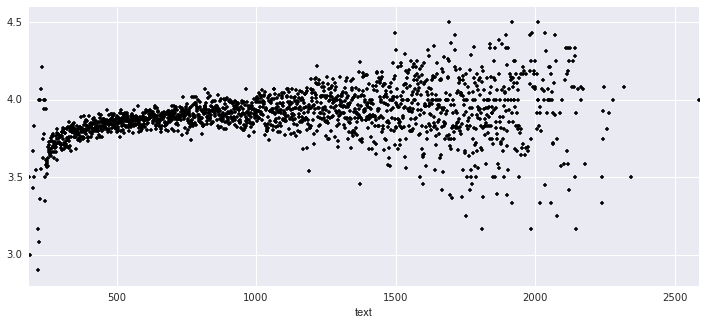

In [36]:
ax = (df.groupby(df.text.str.len())
   .review_overall.agg(['mean', 'std', 'count'])
   .query('count > 5')['mean']
   .plot(style='k.', figsize=(12, 5))
 )

In [39]:
df.text.str.split().apply(len)

TypeError: object of type 'float' has no len()

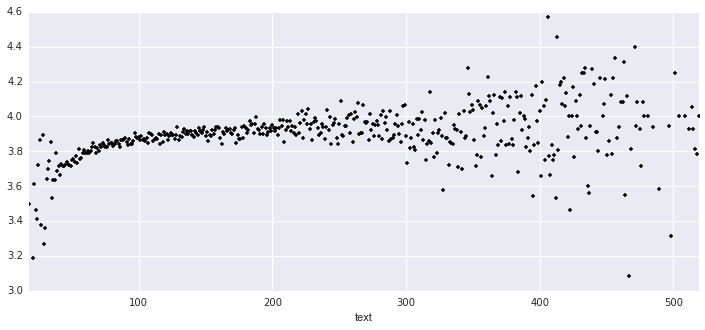

In [42]:
ax = (df.groupby(df.text.str.count(' '))
   .review_overall.agg(['mean', 'std', 'count'])
   .query('count > 5')['mean']
   .plot(style='k.', figsize=(12, 5))
 )

In [29]:
import statsmodels.api as sm

In [30]:
y = sm.nonparametric.lowess(df.review_overall, df.text.str.len())

In [33]:
import matplotlib.pyplot as plt

In [104]:
%matplotlib inline

from itertools import islice
from toolz import partitionby

import numpy as np
import pandas as pd

pd.options.display.max_rows = 10

In [36]:
f = open('../data/beeradvocate.txt')
f.readlines(545)

['beer/name: Sausa Weizen\n',
 'beer/beerId: 47986\n',
 'beer/brewerId: 10325\n',
 'beer/ABV: 5.00\n',
 'beer/style: Hefeweizen\n',
 'review/appearance: 2.5\n',
 'review/aroma: 2\n',
 'review/palate: 1.5\n',
 'review/taste: 1.5\n',
 'review/overall: 1.5\n',
 'review/time: 1234817823\n',
 'review/profileName: stcules\n',
 'review/text: A lot of foam. But a lot.\tIn the smell some banana, and then lactic and tart. Not a good start.\tQuite dark orange in color, with a lively carbonation (now visible, under the foam).\tAgain tending to lactic sourness.\tSame for the taste. With some yeast and banana.\t\t\n',
 '\n',
 'beer/name: Red Moon\n']

In [48]:
f.seek(0)
reviews = filter(lambda x: x != ('\n',), partitionby(lambda x: x == '\n', f))

In [49]:
review = next(reviews)
review

('beer/name: Sausa Weizen\n',
 'beer/beerId: 47986\n',
 'beer/brewerId: 10325\n',
 'beer/ABV: 5.00\n',
 'beer/style: Hefeweizen\n',
 'review/appearance: 2.5\n',
 'review/aroma: 2\n',
 'review/palate: 1.5\n',
 'review/taste: 1.5\n',
 'review/overall: 1.5\n',
 'review/time: 1234817823\n',
 'review/profileName: stcules\n',
 'review/text: A lot of foam. But a lot.\tIn the smell some banana, and then lactic and tart. Not a good start.\tQuite dark orange in color, with a lively carbonation (now visible, under the foam).\tAgain tending to lactic sourness.\tSame for the taste. With some yeast and banana.\t\t\n')

In [55]:
!wc -l ../data/beeradvocate.txt

 22212596 ../data/beeradvocate.txt


In [136]:
def to_json(reviews, i):
    with open('reviews-{}.json'.format(i), 'w') as f:
        json.dump(reviews, f)

In [137]:
with open('../data/beeradvocate.txt') as f:
    reviews = filter(lambda x: x != ('\n',),
                     partitionby(lambda x: x == '\n', f))
    reviews = map(format_review, reviews)
    reviews = partition(10000, reviews, pad=None)
    reviews = filter(None, reviews)
    for i, subset in enumerate(reviews):
        to_json(subset, i)
        print(i, end='\r')



In [127]:
# %load ../data/parse_beer.py
from itertools import islice

import pandas as pd
from toolz import partitionby, partition


def format_review(review):
    return dict(map(lambda x: x.strip().split(":", 1), review))

with open('../data/beeradvocate.txt') as f:
    reviews = filter(lambda x: x != ('\n',),
                     partitionby(lambda x: x == '\n', f))
    reviews = map(format_review, reviews)
    subset = islice(reviews, 100000)
    df = pd.DataFrame(list(subset))


col_names = {
    'beer/ABV': 'abv',
    'beer/beerId': 'beer_id',
    'beer/brewerId': 'brewer_id',
    'beer/name': 'beer_name',
    'beer/style': 'beer_style',
    'review/appearance': 'review_appearance',
    'review/aroma': 'review_aroma',
    'review/overall': 'review_overall',
    'review/palate': 'review_palate',
    'review/profileName': 'profile_name',
    'review/taste': 'review_taste',
    'review/text': 'text',
    'review/time': 'time'
}

numeric = ['abv', 'review_appearance', 'review_aroma',
           'review_overall', 'review_palate', 'review_taste']
df = (df.rename(columns=col_names)
        .replace('', np.nan))
df[numeric] = df[numeric].astype(float)
df['time'] = pd.to_datetime(df.time.astype(int), unit='s')


In [96]:
import seaborn as sns

In [91]:
df[numeric] = df[numeric].astype(float)

In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 13 columns):
abv                  97223 non-null float64
beer_id              100000 non-null object
brewer_id            100000 non-null object
beer_name            100000 non-null object
beer_style           100000 non-null object
review_appearance    100000 non-null float64
review_aroma         100000 non-null float64
review_overall       100000 non-null float64
review_palate        100000 non-null float64
profile_name         99985 non-null object
review_taste         100000 non-null float64
text                 99975 non-null object
time                 100000 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(6), object(6)
memory usage: 10.7+ MB


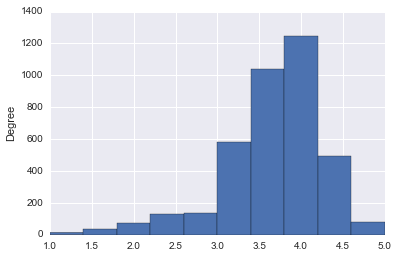

In [110]:
df.groupby('beer_id').review_overall.mean().plot(kind='hist', bins=10)

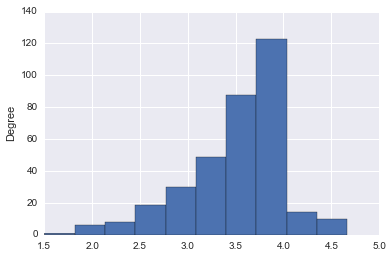

In [111]:
df.groupby('brewer_id').review_overall.mean().plot(kind='hist', bins=10)

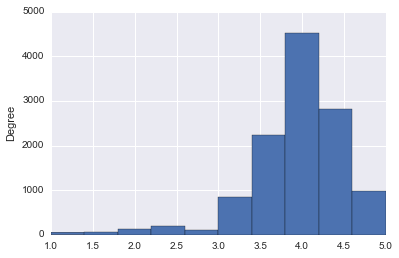

In [113]:
df.groupby('profile_name').review_overall.mean().plot(kind='hist', bins=10)

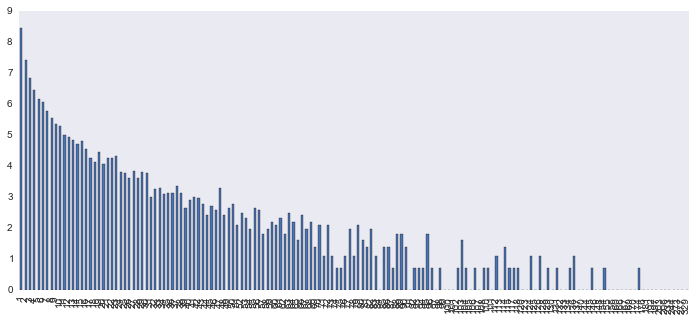

In [123]:
df.profile_name.value_counts().value_counts().sort_index().pipe(np.log).plot(kind='bar', grid=False, figsize=(12, 5))

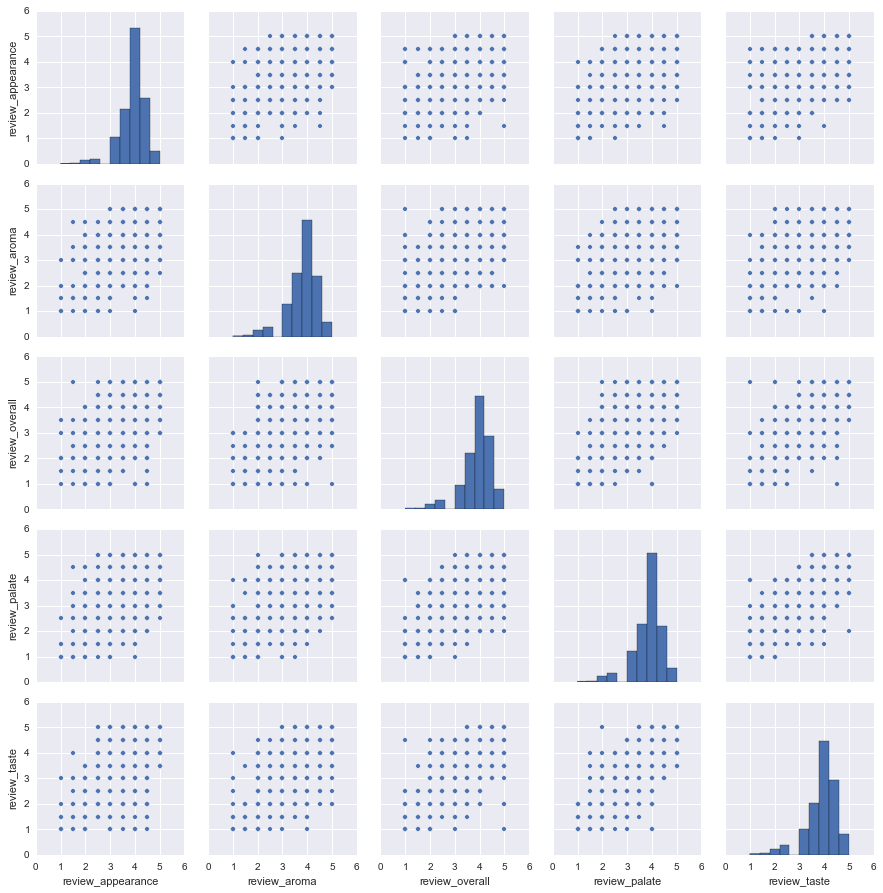

In [102]:
sns.pairplot(df.sample(5000),
             vars=['review_appearance', 'review_aroma', 'review_overall', 'review_palate', 'review_taste'])

In [56]:
import dask.dataframe as dd
df = dd.read_csv('../data/beer_reviews/*.csv')
counts = df.profile_name.value_counts().compute().nlargest(100)
top_users = counts.nlargest(100)
top_users
%time
top = df[df.profile_name.isin(top_users.index)].compute()
top.to_csv('top_users_beer.csv', index=False)
top = pd.read_csv('top_users_beer.csv')
top.head()
review_cols = ['review_appearance', 'review_aroma', 'review_overall',
               'review_palate', 'review_taste']
cols = ['beer_name', 'beer_style', 'profile_name']
top[cols] = top[cols].apply(lambda x: x.str.strip())
top.profile_name.value_counts().plot(kind='hist', color='k')